# Indonesian Coastlines Combined


* Load stack of all available Landsat 5, 7, 8 and 9 satellite imagery for a location 
* Convert each satellite image into a remote sensing water index (MNDWI)
* For each satellite image, model ocean tides into a grid based on exact time of image acquisition
* Interpolate tide heights into spatial extent of image stack using the [FES2014 global tide model](https://github.com/GeoscienceAustralia/dea-coastlines/wiki/Setting-up-tidal-models-for-DEA-Coastlines)
* Mask out high and low tide pixels by removing all observations acquired outside of 50 percent of the observed tidal range centered over mean sea level
* Combine tidally-masked data into annual median composites representing the most representative position of the coastline at approximately mean sea level each year
* Apply morphological extraction algorithms to mask annual median composite rasters to a valid coastal region
* Extract waterline vectors using subpixel waterline extraction ([Bishop-Taylor et al. 2019b](https://doi.org/10.3390/rs11242984))
* Compute rates of coastal change at every 30 m using linear regression

This is an interactive version of the code intended for prototyping; to run this analysis at scale, use the [command line tools](DEACoastlines_generation_CLI.ipynb).

---

## Getting started

Set working directory to top level of repository to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/coastlines


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from odc.stac import configure_s3_access
from dea_tools.spatial import subpixel_contours
from datacube.utils.dask import start_local_dask
import geopandas as gpd
from pathlib import Path

from coastlines.vector import (
    contours_preprocess,
    contour_certainty,
    points_certainty,
    generate_hotspots,
)

from coastlines.combined import (
    load_and_mask_data,
    export_results,
    filter_by_tides,
    generate_yearly_composites,
    mask_pixels_by_tide,
    sanitise_tile_id,
    mask_pixels_by_hillshadow,
)

from ipyleaflet import basemaps

from coastlines.grids import INDONESIA_10KM

from coastlines.utils import CoastlinesException, load_config, get_study_geobox_from_grid
import os

os.environ["USE_PYGEOS"] = "0"

In [4]:
os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

if "AWS_NO_SIGN_REQUEST" in os.environ:
    del os.environ["AWS_NO_SIGN_REQUEST"]

In [5]:
# Create local dask client for parallelisation
dask_client = start_local_dask(
    n_workers=2, threads_per_worker=4, mem_safety_margin="10GB"
)

# Configure S3 access including request payer
_ = configure_s3_access(
    requester_pays=True,
    cloud_defaults=True,
)

dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/rifqi.muhammad@big.go.id/proxy/8787/status,
Dashboard: /user/rifqi.muhammad@big.go.id/proxy/8787/status,Workers: 2
Total threads: 8,Total memory: 18.69 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43931,Workers: 0
Dashboard: /user/rifqi.muhammad@big.go.id/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35985,Total threads: 4
Dashboard: /user/rifqi.muhammad@big.go.id/proxy/33079/status,Memory: 9.34 GiB
Nanny: tcp://127.0.0.1:33323,


## Setup

### Set analysis parameters

In [6]:
# Config
version = "testing"
config_path = "configs/indonesia_coastlines_config_datacube_development.yaml"
config = load_config(config_path)

# Tide data and config
home = Path("~")
tide_data_location = f"{home}/jovyan/data/coastlines/tide_models"

DEBUG = True

In [7]:
# Check tide models
from eo_tides.utils import list_models

models = list_models(directory=tide_data_location, show_supported=False)
print(models)

────────────────────────────────────────────────────────────────────────────────
 󠀠🌊  | Model                | Expected path                                                               
────────────────────────────────────────────────────────────────────────────────
 ✅  │ EOT20                │ /home/jovyan/data/coastlines/tide_models/EOT20/ocean_tides                  
 ✅  │ EOT20_load           │ /home/jovyan/data/coastlines/tide_models/EOT20/load_tides                   
 ✅  │ FES2014              │ /home/jovyan/data/coastlines/tide_models/fes2014/ocean_tide                 
 ✅  │ FES2014_extrapolated │ /home/jovyan/data/coastlines/tide_models/fes2014/ocean_tide_extrapolated    
 ✅  │ FES2014_load         │ /home/jovyan/data/coastlines/tide_models/fes2014/load_tide                  
 ✅  │ FES2022              │ /home/jovyan/data/coastlines/tide_models/fes2022b/ocean_tide_20241025       
 ✅  │ FES2022_extrapolated │ /home/jovyan/data/coastlines/tide_models/fes2022b/ocean_tide_extra

In [8]:
# Study area selection
study_area = (1839, 49)

# Load the geometry from the grid used for the location
geobox = get_study_geobox_from_grid(study_area, INDONESIA_10KM)

# View the AoI
geobox.explore(tiles=basemaps.Esri.WorldImagery)

In [9]:
# Output config
output_dir = Path(
    f"{config.output.location.rstrip('/')}/{version}/{sanitise_tile_id(study_area)}_{version}"
)
output_dir.mkdir(exist_ok=True, parents=True)
output_cache_zarr = (
    output_dir / f"{sanitise_tile_id(study_area)}_{version}_combined_ds.zarr"
)

## Loading data

### Create spatiotemporal query using a STAC API as the backend
This establishes the spatial and temporal extent used to search for Landsat satellite data.


In [10]:
# Load the data, mask it and generate composites.
# This is lazy-loaded, so no data is actually loaded yet.
ds, suninfo_by_day, meta = load_and_mask_data(
    config,
    geobox=geobox,
    include_nir=config.options.include_nir,
    debug=DEBUG,
    use_datacube=config.use_datacube
)

ds

Loading with datacube


Found 766 datasets


<xarray.Dataset> Size: 5GB
Dimensions:      (time: 566, y: 676, x: 666)
Coordinates:
  * y            (y) float64 5kB -7.468e+05 -7.468e+05 ... -7.67e+05 -7.67e+05
  * x            (x) float64 5kB 2.801e+05 2.801e+05 2.802e+05 ... 3e+05 3e+05
    spatial_ref  int32 4B 32649
  * time         (time) datetime64[ns] 5kB 2019-01-07T02:53:46.167949 ... 202...
Data variables:
    green        (time, y, x) float32 1GB dask.array<chunksize=(1, 676, 666), meta=np.ndarray>
    swir16       (time, y, x) float32 1GB dask.array<chunksize=(1, 676, 666), meta=np.ndarray>
    qa_pixel     (time, y, x) float32 1GB dask.array<chunksize=(1, 676, 666), meta=np.ndarray>
    nir08        (time, y, x) float32 1GB dask.array<chunksize=(1, 676, 666), meta=np.ndarray>
    mndwi_nir    (time, y, x) float32 1GB dask.array<chunksize=(1, 676, 666), meta=np.ndarray>

## Tidal modelling


### Interpolate tides into each satellite timestep
For each satellite timestep, model tide heights into a low-resolution 5 x 5 km grid (matching resolution of the FES2014 tidal model), then reproject modelled tides into the spatial extent of our satellite image. Add  this new data as a new variable in our satellite dataset to allow each satellite pixel to be analysed and filtered/masked based on the tide height at the exact moment of satellite image acquisition. 

In [11]:
filtered = filter_by_tides(ds, tide_data_location, config.options.tide_centre, config.options.tide_model, ensemble_model_list=config.options.ensemble_model_list, ensemble_model_rankings=config.options.ensemble_model_rankings)

print(
    f"Dropped {len(ds.time) - len(filtered.time)} out of {len(ds.time)} timesteps due to extreme tides"
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2022
Returning low resolution tide array
Dropped 111 out of 566 timesteps due to extreme tides


## Generate yearly composites in memory
Export tidally-masked MNDWI median composites for each year, and three-yearly composites used to gapfill poor data coverage areas.

In [12]:
# Optionally load the daily dataset into memory, either do this here or
# down below for the combined dataset. This takes more memory, but is
# faster. The below one results in a big, complex dask graph, but saves
# a fair bit of memory.
filtered = filtered.compute()
filtered

<xarray.Dataset> Size: 4GB
Dimensions:      (time: 455, y: 676, x: 666)
Coordinates:
  * y            (y) float64 5kB -7.468e+05 -7.468e+05 ... -7.67e+05 -7.67e+05
  * x            (x) float64 5kB 2.801e+05 2.801e+05 2.802e+05 ... 3e+05 3e+05
    spatial_ref  int32 4B 32649
  * time         (time) datetime64[ns] 4kB 2019-01-07T02:53:46.167949 ... 202...
    tide_model   <U7 28B 'FES2022'
Data variables:
    green        (time, y, x) float32 819MB 0.02844 nan nan nan ... nan nan nan
    swir16       (time, y, x) float32 819MB 0.0005575 nan nan ... nan nan nan
    qa_pixel     (time, y, x) float32 819MB 2.195e+04 nan nan ... nan nan nan
    nir08        (time, y, x) float32 819MB -0.00651 nan nan nan ... nan nan nan
    mndwi_nir    (time, y, x) float32 819MB 1.012 nan nan nan ... nan nan nan

## Specific masking

First we do a per-pixel mask of the extreme tide pixels. This is done with data loaded into memory, to keep things efficient on memory and dask graphs.

The graph below shows the percentage of data remaining each year after per-pixel masking.

Second we do per-pixel hillshadow masking.

### Per-pixel tide masking

In [13]:
# Per-pixel tide masking
pixel_tide_masked = mask_pixels_by_tide(
    filtered,
    tide_data_location,
    config.options.tide_centre,
    config.options.tide_model,
    ensemble_model_list=config.options.ensemble_model_list,
    ensemble_model_rankings=config.options.ensemble_model_rankings,
)

Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2022
Returning low resolution tide array
Creating reduced resolution 5000 x 5000 metre tide modelling array
Modelling tides with FES2022
Reprojecting tides into original resolution


/opt/conda/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/opt/conda/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


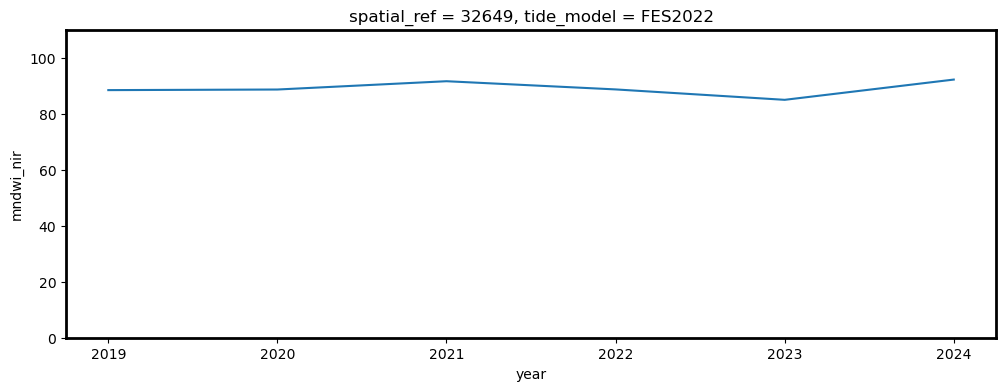

In [14]:
# Plot the percentage of pixels remaining after high-res tide masking
filter_null_byyear = (
    filtered[config.options.water_index]
    .isnull()
    .groupby("time.year")
    .sum(dim=["time", "x", "y"])
)
masked_null_byyear = (
    pixel_tide_masked[config.options.water_index]
    .isnull()
    .groupby("time.year")
    .sum(dim=["time", "x", "y"])
)
diff = (filter_null_byyear / masked_null_byyear) * 100
diff.plot.line(x="year", ylim=[0, 110], figsize=(12, 4), yticks=range(0, 101, 20))

### Per-pixel hillshade masking

(Optional)

In [ ]:
# Run a hillshade masking step. This is optional, but can help remove
# some noisy pixels from the analysis.

if config.options.mask_with_hillshade:
    try:
        pixel_tide_masked, hillshade = mask_pixels_by_hillshadow(
            pixel_tide_masked, 
            suninfo_by_day, 
            stac_catalog = config.options.hillshade_stac_catalog,
            stac_collection = config.options.hillshade_stac_collection,
            debug=True
        )
    except CoastlinesException:
        print("No DEM available for this area. Skipping hillshade masking.")

In [ ]:
# In the below plot, anything that isn't a `0` has had some
# pixels masked out due to hillshade.
mean_hs = hillshade.mean(dim="time")
mean_hs.plot.imshow(size=10, vmin=0, vmax=1)

In [ ]:
# Plot the percentage of pixels remaining after hillshade masking
shaded_null_byyear = (
    pixel_tide_masked[config.options.water_index]
    .isnull()
    .groupby("time.year")
    .sum(dim=["time", "x", "y"])
)
diff = (masked_null_byyear / shaded_null_byyear) * 100
diff.plot.line(x="year", ylim=[0, 110], figsize=(12, 4), yticks=range(0, 101, 20))

## Create annual composites

In [15]:
# Create a yearly dataset, loaded into memory. This takes a long time!
combined_ds = generate_yearly_composites(
    pixel_tide_masked,
    config.options.start_year,
    config.options.end_year,
    water_index=config.options.water_index,
    include_nir=config.options.include_nir,
    debug=DEBUG,
)

# Load the combined dataset instead. Make sure you comment out the filtered
# load step. This will take longer, but use less memory.
combined_ds = combined_ds.compute()
combined_ds

Water index is mndwi_nir


<xarray.Dataset> Size: 101MB
Dimensions:            (year: 4, y: 676, x: 666)
Coordinates:
  * y                  (y) float64 5kB -7.468e+05 -7.468e+05 ... -7.67e+05
  * x                  (x) float64 5kB 2.801e+05 2.801e+05 ... 3e+05 3e+05
    spatial_ref        int32 4B 32649
    tide_model         <U7 28B 'FES2022'
  * year               (year) int64 32B 2020 2021 2022 2023
Data variables:
    mndwi_nir          (year, y, x) float32 7MB 0.946 0.9391 ... 0.3294 0.3483
    count              (year, y, x) int64 14MB 12 12 13 13 12 ... 23 24 24 25 25
    stdev              (year, y, x) float32 7MB 0.03198 0.03173 ... 0.1826
    gapfill_mndwi_nir  (year, y, x) float32 7MB 0.9371 0.9369 ... 0.2594 0.2758
    gapfill_count      (year, y, x) int64 14MB 37 36 37 37 35 ... 54 55 56 58 58
    gapfill_stdev      (year, y, x) float32 7MB 0.04314 0.04252 ... 0.1691
    nir                (year, y, x) float32 7MB 0.02138 0.02133 ... 0.2556
    gapfill_nir        (year, y, x) float32 7MB 0.0203 0.02011 ... 0.2846 0.2701
    green              (year, y, x) float32 7MB 0.06012 0.06092 ... 0.07662
    swir               (year, y, x) float32 7MB 0.01083 0.01179 ... 0.1317
    gapfill_green      (year, y, x) float32 7MB 0.06441 0.06542 ... 0.07063
    gapfill_swir       (year, y, x) float32 7MB 0.01131 0.01242 ... 0.142 0.142

In [16]:
combined_ds["mndwi_nir"].isel(year=-1).odc.explore(
    robust=True, cmap="RdBu", vmin=-0.2, vmax=1
)

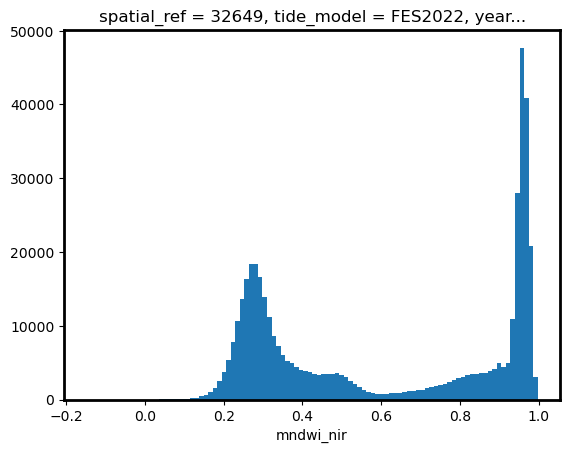

In [17]:
_ = combined_ds["mndwi_nir"].isel(year=-1).plot.hist(bins=100)

In [18]:
# Uncomment the below to save data

if output_cache_zarr.exists():
    import shutil

    print(f"Folder {output_cache_zarr} already exists. Deleting...")
    shutil.rmtree(output_cache_zarr)

combined_ds.to_zarr(output_cache_zarr)

/opt/conda/lib/python3.12/site-packages/zarr/api/asynchronous.py:228: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [20]:
# Uncomment the below to load data
import xarray as xr

combined_ds = xr.open_zarr(output_cache_zarr).load()
combined_ds

<xarray.Dataset> Size: 101MB
Dimensions:            (year: 4, y: 676, x: 666)
Coordinates:
  * y                  (y) float64 5kB -7.468e+05 -7.468e+05 ... -7.67e+05
    tide_model         <U7 28B 'FES2022'
  * year               (year) int64 32B 2020 2021 2022 2023
  * x                  (x) float64 5kB 2.801e+05 2.801e+05 ... 3e+05 3e+05
    spatial_ref        int32 4B 32649
Data variables:
    swir               (year, y, x) float32 7MB 0.01083 0.01179 ... 0.1317
    gapfill_swir       (year, y, x) float32 7MB 0.01131 0.01242 ... 0.142 0.142
    count              (year, y, x) int64 14MB 12 12 13 13 12 ... 23 24 24 25 25
    green              (year, y, x) float32 7MB 0.06012 0.06092 ... 0.07662
    gapfill_count      (year, y, x) int64 14MB 37 36 37 37 35 ... 54 55 56 58 58
    nir                (year, y, x) float32 7MB 0.02138 0.02133 ... 0.2556
    stdev              (year, y, x) float32 7MB 0.03198 0.03173 ... 0.1826
    gapfill_stdev      (year, y, x) float32 7MB 0.04314 0.04252 ... 0.1691
    gapfill_green      (year, y, x) float32 7MB 0.06441 0.06542 ... 0.07063
    gapfill_mndwi_nir  (year, y, x) float32 7MB 0.9371 0.9369 ... 0.2594 0.2758
    mndwi_nir          (year, y, x) float32 7MB 0.946 0.9391 ... 0.3294 0.3483
    gapfill_nir        (year, y, x) float32 7MB 0.0203 0.02011 ... 0.2846 0.2701

## Load vector data and pre-process raster data

In [21]:
# Coastal mask modifications with "add" and "remove" areas
modifications_gdf = gpd.read_file(config.input.modifications_path, mask=geobox.geographic_extent).to_crs(
    str(combined_ds.odc.crs)
)

# Mask dataset to focus on coastal zone only
(
    masked_ds,
    certainty_masks,
    all_time_20,
    all_time_80,
    river_mask,
    ocean_da,
    thresholded_ds,
    temporal_mask,
    annual_mask,
    coastal_mask,
    ocean_mask,
) = contours_preprocess(
    combined_ds=combined_ds,
    water_index=config.options.water_index,
    index_threshold=config.options.index_threshold,
    buffer_pixels=33,
    modifications_gdf=modifications_gdf,
    include_nir=True,
    debug=True,
)

masked_ds.isel(year=0).odc.explore(cmap="RdBu", tiles=basemaps.Esri.WorldImagery)

In [22]:
# Extract shorelines
contours = subpixel_contours(
    da=masked_ds,
    z_values=config.options.index_threshold,
    min_vertices=10,
    dim="year",
).set_index("year")

# Add quality measures
contours_with_certainty = contour_certainty(contours, certainty_masks)

# Plot shorelines
contours_with_certainty.reset_index().explore(
    column="year",
    cmap="magma",
    tiles=basemaps.Esri.WorldImagery
)

Operating in single z-value, multiple arrays mode


## Compute statistics

### Measure annual coastline movements

In [23]:
from coastlines.combined import extract_points_with_movements

points = extract_points_with_movements(
    combined_ds,
    contours_with_certainty,
    config.options.baseline_year,
    config.options.start_year,
    config.options.end_year,
    water_index=config.options.water_index,
)

In [24]:
geomorphology_url = config.input.geomorphology_path
geomorphology_gdf = gpd.read_file(
    geomorphology_url,
    mask=geobox.geographic_extent,
)

# And add certainty
points_with_certainty = points_certainty(
    points,
    geomorphology_gdf=geomorphology_gdf,
    baseline_year=config.options.baseline_year,
    rocky_query="(Preds == 'Bedrock') and (Probs > 0.75)",
)

In [25]:
# Generate hotspots
hotspots = generate_hotspots(
    contours_with_certainty,
    points_with_certainty,
    [10000, 5000, 1000],
    config.options.baseline_year,
)

# Visualise the 10_000 m hotspots
hotspots[0].explore(
    column="rate_time",
    cmap="RdYlGn",
    marker_kwds={
        "radius": 10,
        "fill_opacity": 0.8,
    },
    tiles=basemaps.Esri.WorldImagery
)

## Export files

In [26]:
clipped_points_gdf = points_with_certainty.clip(
    geobox.geographic_extent.to_crs(points_with_certainty.crs)
)
clipped_contours_gdf = contours_with_certainty.clip(
    geobox.geographic_extent.to_crs(contours_with_certainty.crs)
)

out_files = export_results(
    clipped_points_gdf, clipped_contours_gdf, version, str(output_dir), study_area
)

for out_file in out_files:
    print(f"Exported {out_file}")

TypeError: object of type 'Geometry' has no len()

### Close Dask client

In [ ]:
dask_client.close()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/dea-coastlines/issues/new).

**Last modified:** November 2022

**To cite:**

> Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia's dynamic coastline at mean sea level using three decades of Landsat imagery. Remote Sensing of Environment, 267, 112734. Available: https://doi.org/10.1016/j.rse.2021.112734
>
> Nanson, R., Bishop-Taylor, R., Sagar, S., Lymburner, L., (2022). Geomorphic insights into Australia's coastal change using a national dataset derived from the multi-decadal Landsat archive. Estuarine, Coastal and Shelf Science, 265, p.107712. Available: https://doi.org/10.1016/j.ecss.2021.107712
>
> Bishop-Taylor, R., Sagar, S., Lymburner, L., Alam, I., Sixsmith, J. (2019). Sub-pixel waterline extraction: characterising accuracy and sensitivity to indices and spectra. Remote Sensing, 11 (24):2984. Available: https://doi.org/10.3390/rs11242984